In [1]:
from ortools.linear_solver import pywraplp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math as m

In [2]:
areaDataframe = pd.read_csv('areaData.csv')

In [3]:
areaDataframe.head()

,section,width,length,area
0,1,1.57,10.18,15.9826
1,2,2.14,7.64,16.3496
2,3,1.57,10.18,15.9826
3,4,1.57,14.56,22.8592
4,5,2.14,12.14,25.9796


In [5]:
maxArea = areaDataframe['area'].values #in m^2
maxArea

array([15.9826, 16.3496, 15.9826, 22.8592, 25.9796, 25.4026, 18.9342,
       23.219 , 18.9342, 13.9573, 16.3496, 13.9573, 15.6434, 33.8954,
       15.6434, 20.7152, 37.2788, 20.7152,  9.5123, 19.0246,  9.5123,
        4.7508,  9.5016,  4.7508])

In [6]:
# Create a solver
solver = pywraplp.Solver.CreateSolver('GLOP')

# Define decision variables
n_classes = 4
n_sections = maxArea.size
seats = {}
cost = [864, 2054,5763,12184] #economic, premium, business, first
weight = [64,64,64,64] #economic, premium, business, first (in Kg)
max_weight = 395000 #in Kg
demand = [np.infty, 250,50,26] # economic, premium, business, first
sizes = [0.39,0.478,1.06,1.829] #economic, premium, business, first (in m^2)

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i, j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

# Area constraint
for j in range(n_sections):
    solver.Add(
        solver.Sum(seats[i, j] * sizes[i] for i in range(n_classes)) <= maxArea[j]
    )

# Weight constraint
weight_constraint = solver.Sum(
    seats[i, j] * weight[i] 
    for i in range(n_classes) 
    for j in range(n_sections)
) <= max_weight

# Demand constraint
for i in range(n_classes):
    solver.Add(
        (solver.Sum(seats[i, j] for j in range(n_sections)) <= demand[i])
    )


In [28]:
# Solve the problem
status = solver.Solve()

# Get the optimal solution

if status == pywraplp.Solver.OPTIMAL:
    print(f'Objective value revenue = ${np.round(solver.Objective().Value(), 2)}')
else:
    print('The problem does not have an optimal solution.')

Objective value revenue = $1581000.99


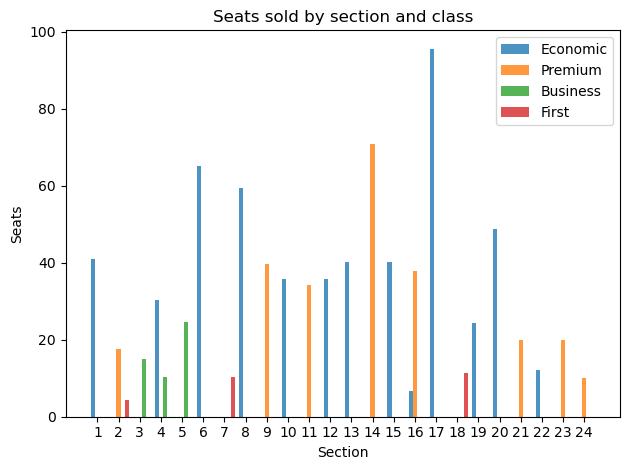

In [8]:
# Create a histogram of each section and show the distribution of seats sold in each class
fig, ax = plt.subplots()
index = np.arange(n_sections)
bar_width = 0.2
opacity = 0.8
class_labels = ['Economic', 'Premium', 'Business', 'First']

for i in range(n_classes):
    values = [seats[i, j].solution_value() for j in range(n_sections)]
    ax.bar(index + i * bar_width, values, bar_width, alpha=opacity, label=class_labels[i])

ax.set_xlabel('Section')
ax.set_ylabel('Seats')
ax.set_title('Seats sold by section and class')
ax.legend()

ax.set_xticks(index + bar_width)
ax.set_xticklabels(index)

#move the x axis +1 so counts start from 1
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(float(label)) + 1 for label in labels]
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

In [9]:
all_values = []
seats_class = []  # number of seats per class

for i in range(n_classes):
    values = [m.floor(seats[i, j].solution_value()) for j in range(n_sections)]
    all_values.append(values)
    seats_sum = np.sum(values)
    seats_class.append(seats_sum)


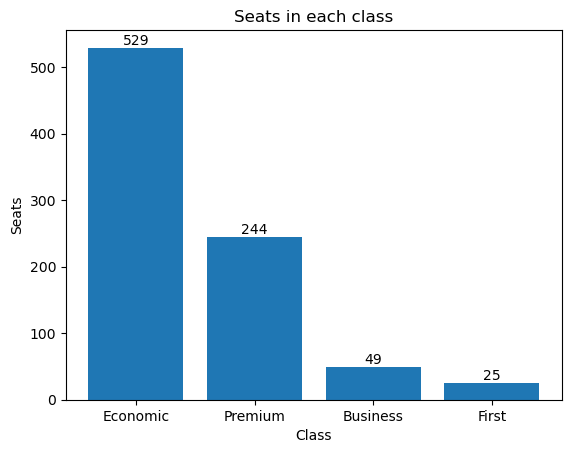

In [22]:
fig, ax = plt.subplots()
ax.bar(class_labels, seats_class)
ax.set_xlabel('Class')
ax.set_ylabel('Seats')
ax.set_title('Seats in each class')

for i, v in enumerate(seats_class):
    ax.text(i, v + 5, f'{np.round(v, 2)}', ha='center')

In [ ]:
calc_costs = []
class_cost = []  # revenue per class

for row in range(n_classes):
    rev = [all_values[row][col] * cost[row] for col in range(n_sections)]
    calc_costs.append(rev)
    class_rev = np.sum(rev)
    class_cost.append(class_rev)


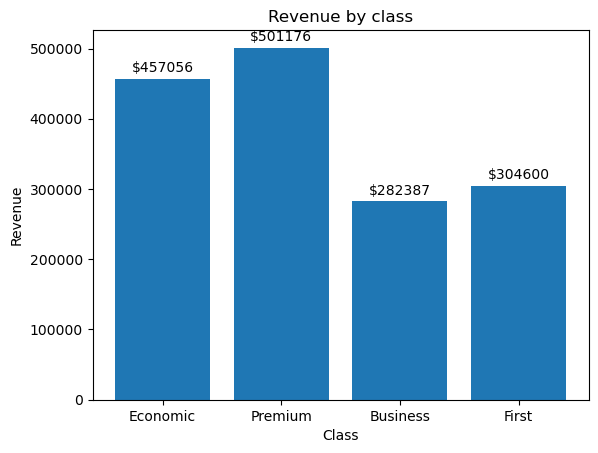

In [ ]:
fig, ax = plt.subplots()
ax.bar(class_labels, class_cost)
ax.set_xlabel('Class')
ax.set_ylabel('Revenue')
ax.set_title('Revenue by class')

for i, v in enumerate(class_cost):
    ax.text(i, v + 10000, f'${np.round(v, 2)}', ha='center')